# Requirements

In [ ]:
! pip install simpledorff==0.0.2
! pip install twitter-text-parser==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Feger/twitter-taco-dataset

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Feger/twitter-taco-dataset


In [ ]:
import pandas as pd
from tqdm import tqdm; tqdm.pandas()
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import simpledorff as iaa
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from twitter_text import parse_tweet, extract_urls_with_indices, extract_emojis_with_indices
import json
from spacy.lang.en import English

In [ ]:
df_decisions = pd.read_csv('./data/worker_decisions.csv', index_col='tweet_id')

assert df_decisions.information.dtype == 'int'
assert set(df_decisions.information.unique()) == {0, 1}

assert df_decisions.inference.dtype == 'int'
assert set(df_decisions.inference.unique()) == {0, 1}

assert df_decisions.confidence.dtype == 'int'
assert set(df_decisions.confidence.unique()) == {1, 2, 3}

In [ ]:
df_conversations = pd.read_csv('./data/conversations.csv', index_col='conversation_id')
assert df_conversations.parent_id.isin(df_conversations.tweet_id).all()

In [ ]:
df_backup = pd.read_csv('./data/backup_tweets.csv', index_col='tweet_id', lineterminator='\n')

In [ ]:
df_conversations = df_conversations.join(df_backup, on='tweet_id')

# Inter-Annotator-Aggreement

In [ ]:
def get_iaa(df, variable):
    """This method returns the Krippendorff alpha of a given dataframe for the specified variable."""
    return round(iaa.calculate_krippendorffs_alpha_for_df(df,
                                                          experiment_col='tweet_id',
                                                          annotator_col='worker',
                                                          class_col=variable), 3)

In [ ]:
NONE = "None"
NOTIFICATION = "Notification"
STATEMENT = "Statement"
REASON = "Reason"

order_of_label = [REASON, STATEMENT, NOTIFICATION, NONE]

def aggregate_classes(row):
    """This method aggregates the proposed classes by their constituting elements."""
    has_information = row["information"]
    has_inference = row["inference"]

    if not has_information and not has_inference:
        return NONE
    if has_information and not has_inference:
        return NOTIFICATION
    if not has_information and has_inference:
        return STATEMENT
    if has_information and has_inference:
        return REASON
    return "ERROR"

In [ ]:
# for each worker individually add the observed class.
df_decisions['class'] = df_decisions.progress_apply(lambda row: aggregate_classes(row), axis=1)

100%|██████████| 6342/6342 [00:00<00:00, 100184.84it/s]


In [ ]:
def summarize_annotations(df):
    """This method returns a summary regarding the IAA of a dataframe holding annotations for information, inference and class."""
    df = df.copy()
    tweets = set(df.index.unique())
    workers = set(df.worker.unique())
    if 'A' in workers:
        workers -= {'E'} # A == E
    print('{t} tweets rated by {w} workers'.format(t=len(tweets), w=len(workers)))
    for field in ['inference', 'information', 'class']:
        df.reset_index(drop=False, inplace=True)
        print(f"Krippendorff's alpha {field}:", get_iaa(df, field))

In [ ]:
# overall IAA of phase 1
summarize_annotations(df_decisions[df_decisions.worker.isin(['A', 'B', 'C', 'D'])])

600 tweets rated by 4 workers
Krippendorff's alpha inference: 0.614
Krippendorff's alpha information: 0.637
Krippendorff's alpha class: 0.581


In [ ]:
# overall IAA of phase 2
summarize_annotations(df_decisions[df_decisions.worker.isin(['E', 'F', 'G'])])

1314 tweets rated by 3 workers
Krippendorff's alpha inference: 0.869
Krippendorff's alpha information: 0.818
Krippendorff's alpha class: 0.812


In [ ]:
# 100 controll tweets between phase 1 and 2
df_p1 = df_decisions[df_decisions.worker.isin(['A', 'B', 'C', 'D'])]
df_p2 = df_decisions[df_decisions.worker.isin(['E', 'F', 'G'])]
# select the starters that where annotated in phase 1 and 2.
df_p2 = df_p2[df_p2.index.isin(df_p1.index)]
df_p1 = df_p1[df_p1.index.isin(df_p2.index)]
# tweets in phase 1 == phase 2
assert sorted(df_p1.index.unique()) == sorted(df_p2.index.unique())
assert df_p1.index.unique().shape[0] == 100
assert df_p2.index.unique().shape[0] == 100

print('Results phase 1:')
summarize_annotations(df_p1)
print('Results phase 2:')
summarize_annotations(df_p2)

Results phase 1:
100 tweets rated by 4 workers
Krippendorff's alpha inference: 1.0
Krippendorff's alpha information: 1.0
Krippendorff's alpha class: 1.0
Results phase 2:
100 tweets rated by 3 workers
Krippendorff's alpha inference: 0.894
Krippendorff's alpha information: 0.91
Krippendorff's alpha class: 0.884


In [ ]:
# A and E share votes (double votes between the phases)
assert df_decisions[df_decisions.worker == 'A'].index.isin(df_decisions[df_decisions.worker == 'E'].index).any()
# remove duplicate votes for A == E
df_no_double_votes = df_decisions[~((df_decisions.index.isin(df_p2.index)) & (df_decisions.worker =='E'))]
assert df_no_double_votes.shape[0] == df_decisions.shape[0] - 100
assert not df_no_double_votes[df_no_double_votes.worker == 'A'].index.isin(df_no_double_votes[df_no_double_votes.worker == 'E'].index).any()
# Assign the remaining votes of E to A.
df_no_double_votes.loc[df_no_double_votes.worker=='E', 'worker'] = 'A'
assert df_no_double_votes.worker.isin(['A', 'B', 'C', 'D', 'F', 'G']).all()

In [ ]:
df_decisions = df_no_double_votes.copy()
# overall IAA
summarize_annotations(df_decisions)

1814 tweets rated by 6 workers
Krippendorff's alpha inference: 0.756
Krippendorff's alpha information: 0.758
Krippendorff's alpha class: 0.718


# Majority Aggregation

In [ ]:
UNDECIDED = 'Undecided'
# create majority votes
unique_index = df_decisions.index.unique()
decisions = list()
for tweet_id in tqdm(unique_index, total=unique_index.shape[0]):
    # get each annotator vote by the tweet_id
    row = df_decisions.loc[tweet_id]
    votes = row['class'].values
    assert len(votes) <= 6
    assert not 'E' in row.worker
    confidences = row['confidence'].values
    # count the class votes for majority vote
    counter = Counter({
        REASON : 0,
        STATEMENT : 0,
        NOTIFICATION : 0,
        NONE : 0})
    counter.update(votes)
    majority_vote = counter.most_common(1)[0]

    # add each majority decision.
    decision = {
        'tweet_id' : tweet_id,
        'topic' : row.topic.unique()[0],
        # the majority vote as class label
        'class': majority_vote[0],
        # given all votes, the class confidence is the percentage of votes contributing to the resulting majority class
        'confidence': round(majority_vote[1]/len(votes), 2)
    }
    if decision['confidence'] <= 0.5:
        decision['class'] = UNDECIDED
    
    decisions += [decision]
# Write the majority labels to a dataframe
df_majority = pd.DataFrame(decisions)

df_majority = df_majority.set_index('tweet_id')
df_majority.to_csv('./data/majority_votes.csv')

100%|██████████| 1814/1814 [00:00<00:00, 2073.25it/s]


In [ ]:
# class distribution
df_majority.groupby('class')['topic'].count()

class
None            369
Notification    500
Reason          581
Statement       284
Undecided        80
Name: topic, dtype: int64

In [ ]:
# confidence distribution
100 * round(df_majority.groupby('confidence')['topic'].count()/df_majority.shape[0], 2)

confidence
0.33     1.0
0.50     4.0
0.67    15.0
0.75    13.0
0.83     0.0
1.00    67.0
Name: topic, dtype: float64

# Structural Statistics

In [ ]:
TOP_LEVEL = "top-level"
CONVERSATION_LEVEL = "conversation-level"

ROOT_TWEET = "root"
STARTER_TWEET = "starter"
REPLY_TWEET = "reply"
DEAD_END_TWEET = "dead-end"

def get_level_tag(row):
    """Given a row having a tweets' id as name, the parent_id and conversation_id, this method returns the corresponding conversation-level."""
    if row.name == row.parent_id == row.tweet_id:
        return TOP_LEVEL
    else:
        return CONVERSATION_LEVEL

def get_role_tag(row):
    """Given a row having a tweets' id, the parent_id and conversation_id, this method returns the role of a tweet in its' conversation."""
    if row.level == TOP_LEVEL:
        if row.conversation_size > 1:
            return STARTER_TWEET
        return ROOT_TWEET
    else:
        if row.parent_id == row.tweet_id:
            return DEAD_END_TWEET
        return REPLY_TWEET

def add_information(df):
    """Given a dataframe having conversational tweets as specified in G, this will add relevant graph information."""
    df_conversation_sizes = df.reset_index().groupby('conversation_id').tweet_id.count()
    df['conversation_size'] = df.progress_apply(lambda row: df_conversation_sizes.loc[row.name], axis=1)
    df['level'] = df.progress_apply(lambda row: get_level_tag(row), axis=1)
    df['role'] = df.progress_apply(lambda row: get_role_tag(row), axis=1)
    return df

df_conversations = add_information(df_conversations)

100%|██████████| 602664/602664 [00:14<00:00, 41057.94it/s]


In [ ]:
def summarize_conversations(df, variables=['topic', 'level', 'role'], global_summary=False):
    """This method summarizes the structure of conversations."""
    if global_summary:
        print(df.groupby(['topic'])['conversation_id'].count())
    else:
        for variable in variables:
            df_var = df.reset_index().groupby(variable).count()['tweet_id']
            df_var = df_var.to_frame('count')
            df_var['percent'] = 100 * round(df_var / df_var.sum(), 3)
            new_row = pd.Series(data=df_var.sum(), name='total')
            df_var = pd.concat([df_var, new_row.to_frame().T])
            print(df_var, '\n')

summarize_conversations(df_conversations)

                    count  percent
abortion          29939.0      5.0
brexit           427260.0     70.9
got               61705.0     10.2
lotrrop           14014.0      2.3
squidgame         51215.0      8.5
twittertakeover   18531.0      3.1
total            602664.0    100.0 

                       count  percent
conversation-level  429420.0     71.3
top-level           173244.0     28.7
total               602664.0    100.0 

             count  percent
dead-end   40537.0      6.7
reply     388883.0     64.5
root      140592.0     23.3
starter    32652.0      5.4
total     602664.0     99.9 



In [ ]:
df_argumentation = df_conversations.reset_index().merge(df_majority['class'], on='tweet_id')
df_top_level = df_argumentation[df_argumentation.role == STARTER_TWEET]
df_conv_level = df_argumentation[df_argumentation.role != STARTER_TWEET]
df_top_level_sampled = df_top_level[df_top_level.conversation_id.isin(df_conv_level.conversation_id.unique())]

assert all(df_top_level.conversation_size >= 2)
assert len(df_argumentation.conversation_id.unique()) == 700

print('+++++++ Summary of all sampled tweets +++++++')
summarize_conversations(df_argumentation)
print('+++++++ Summary of sampled top-level tweets +++++++')
summarize_conversations(df_top_level)
print('+++++++ Summary of sampled conversation-level tweets +++++++')
summarize_conversations(df_conv_level)
print('+++++++ Summary of sampled argumentation (by the starter tweets) +++++++')
# there were 2 conversations (one for both abortion and brexit) with size 2 but the reply was present but the content was restricted (not deleted).
summarize_conversations(df_top_level_sampled, ['topic', 'level', 'role', 'conversation_size'])

+++++++ Summary of all sampled tweets +++++++
                  count  percent
abortion          486.0     26.8
brexit            535.0     29.5
got               192.0     10.6
lotrrop           209.0     11.5
squidgame         226.0     12.5
twittertakeover   166.0      9.2
total            1814.0    100.1 

                     count  percent
conversation-level  1114.0     61.4
top-level            700.0     38.6
total               1814.0    100.0 

           count  percent
dead-end    91.0      5.0
reply     1023.0     56.4
starter    700.0     38.6
total     1814.0    100.0 

+++++++ Summary of sampled top-level tweets +++++++
                 count  percent
abortion         300.0     42.9
brexit           300.0     42.9
got               25.0      3.6
lotrrop           25.0      3.6
squidgame         25.0      3.6
twittertakeover   25.0      3.6
total            700.0    100.2 

           count  percent
top-level  700.0    100.0
total      700.0    100.0 

         count  perc

In [ ]:
df_conv_level_clean = df_conv_level[df_conv_level.role == REPLY_TWEET]
df_end_tweets = df_conv_level_clean[~df_conv_level_clean.tweet_id.isin(df_conv_level_clean.parent_id)]

df_conv_level_dead = df_conv_level[df_conv_level.role == DEAD_END_TWEET]
df_conv_level_dead_end = df_conv_level_dead[~df_conv_level_dead.tweet_id.isin(df_conv_level_clean.parent_id)]

assert any(df_conv_level_dead.tweet_id.isin(df_conv_level_clean.tweet_id)) == False
assert any(df_conv_level_dead_end.tweet_id.isin(df_conv_level_clean.tweet_id)) == False

df_end_tweets = pd.concat([df_end_tweets, df_conv_level_dead_end])

print('Of all tweets ending a conversation branch:')
for cls in [REASON, STATEMENT, NOTIFICATION, NONE]:
    print(f"{cls}:", round(100*(df_end_tweets[df_end_tweets['class'] == cls].shape[0]/df_end_tweets.shape[0]), 2), "%")

Of all tweets ending a conversation branch:
Reason: 29.4 %
Statement: 18.83 %
Notification: 17.89 %
None: 32.79 %


In [ ]:
df_argumentation = df_argumentation[df_argumentation['class'] != UNDECIDED]

# read the individual conversations
def get_pseudo_parents(df):
    C = set(df.tweet_id)  # set of all children.
    P = set(df.parent_id)  # set of all parents.
    # those tweets only present as parent but never as a child.
    onlyP = P.difference(C)
    return onlyP

assert df_argumentation.tweet_id.isin(df_decisions.index).all()

onlyP = get_pseudo_parents(df_argumentation)
df_onlyP = df_argumentation.loc[df_argumentation.parent_id.isin(onlyP)]
df_argumentation.loc[df_onlyP.index, 'parent_id'] = df_onlyP.tweet_id

assert df_argumentation.tweet_id.isin(df_decisions.index).all()
assert df_argumentation.parent_id.isin(df_decisions.index).all()

df_argumentation = df_argumentation.merge(
    df_argumentation[['tweet_id', 'class']],
    left_on='parent_id', right_on='tweet_id',
    suffixes=('', '_parent')
)
df_argumentation = df_argumentation.drop(columns=['tweet_id_parent'])
for _, row in df_argumentation.iterrows():
    assert df_majority.loc[row.tweet_id]['class'] == row['class']
    assert df_majority.loc[row.parent_id]['class'] == row['class_parent']

assert df_argumentation.tweet_id.isin(df_decisions.index).all()
assert df_argumentation.parent_id.isin(df_decisions.index).all()

In [ ]:
def generate_transition_probabilities(pair_list):
    transitions = {}
    for i in range(len(pair_list)-1):
        current = pair_list[i][0]
        next = pair_list[i+1][1]
        if current not in transitions:
            transitions[current] = {}
        if next not in transitions[current]:
            transitions[current][next] = 0
        transitions[current][next] += 1

    for key in transitions:
        total_count = sum(transitions[key].values())
        for subkey in transitions[key]:
            transitions[key][subkey] /= total_count

    return transitions

pairs = df_argumentation[['class', 'class_parent']].values

transitions = generate_transition_probabilities(pairs)

print(json.dumps(transitions, indent=4))

{
    "Reason": {
        "Notification": 0.31153184165232356,
        "Reason": 0.5094664371772806,
        "Statement": 0.12048192771084337,
        "None": 0.058519793459552494
    },
    "Notification": {
        "None": 0.088,
        "Notification": 0.568,
        "Reason": 0.264,
        "Statement": 0.08
    },
    "None": {
        "Notification": 0.4429347826086957,
        "Reason": 0.26358695652173914,
        "Statement": 0.07880434782608696,
        "None": 0.21467391304347827
    },
    "Statement": {
        "Notification": 0.3274647887323944,
        "Statement": 0.2112676056338028,
        "Reason": 0.38028169014084506,
        "None": 0.08098591549295775
    }
}


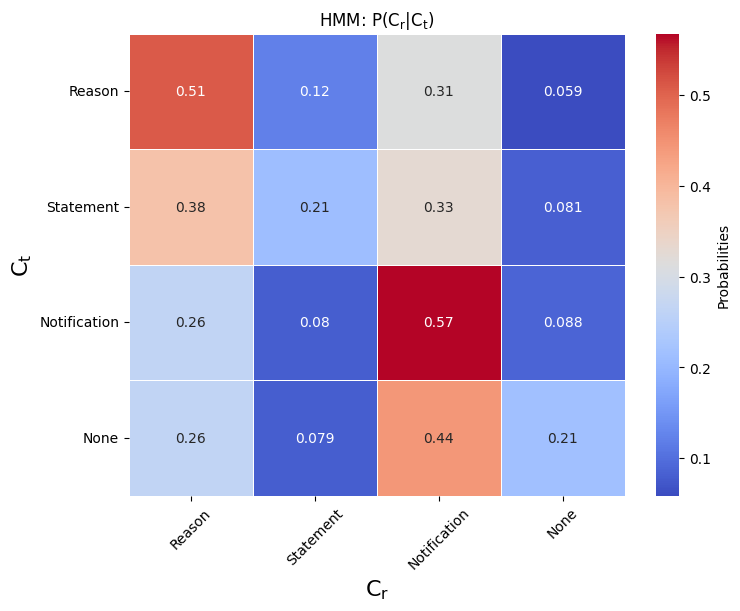

In [ ]:
# convert the dictionary to a pandas dataframe and sort the rows and columns
df = pd.DataFrame.from_dict(transitions)
df = df.reindex(columns=order_of_label, index=order_of_label)

# transpose the dataframe
df = df.T

# create the heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, linewidths=.5, ax=ax,
            xticklabels=df.columns, yticklabels=df.index, 
            cbar_kws={'label': 'Probabilities'})
plt.xlabel(r'$\mathrm{C_r}$', fontsize=16)
plt.ylabel(r'$\mathrm{C_t}$', fontsize=16)
ax.set_title(r'HMM: $\mathrm{P(C_r|C_t)}$')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Textual Statistics

In [ ]:
# opening JSON file
with open('./data/url_dict.json') as json_file:
    url_dict = json.load(json_file)

In [ ]:
def add_information(df):
    df = df.copy()
    nlp = English()

    def process_url(tweet_text, lookup):
        urls = extract_urls_with_indices(tweet_text)
        has_external_url = any('twitter.com' not in url_dict.get(url['url'], None) for url in urls)
        return int(has_external_url)

    def process_emojis(tweet_text):
        return len(extract_emojis_with_indices(tweet_text)) > 0

    def detect_discourse_markers(text):
        discourse_markers = ["actually", "anyway", "basically", "certainly", "clearly", "consequently", "definitely", "evidently",
                     "generally", "however", "incidentally", "indeed", "interestingly", "likewise", "meanwhile", "moreover",
                     "nevertheless", "obviously", "overall", "personally", "previously", "really", "right", "so", "somehow",
                     "sometimes", "specifically", "still", "technically", "therefore", "thus", "unfortunately", "well", "whatever",
                     "whenever", "whereas", "whether", "while", "yet"]
        doc = nlp(text)
        markers = []
        for token in doc:
            if token.lower_ in discourse_markers:
                markers.append(token.lower_)
        return markers
    
    df['length'] = df.progress_apply(lambda row: parse_tweet(row.text).weightedLength, axis=1)
    df['urls'] = df.progress_apply(lambda row: len(extract_urls_with_indices(row.text)), axis=1)
    df['has_external_url'] = df.progress_apply(lambda row: process_url(row.text, url_dict), axis=1)
    df['emojis'] = df.progress_apply(lambda row: len(extract_emojis_with_indices(row.text)), axis=1)
    df['hashtags'] = df.progress_apply(lambda row: Counter(row.text).get('#', 0), axis=1)
    df['users'] = df.progress_apply(lambda row: Counter(row.text).get('@', 0), axis=1)
    df['marker'] = df.progress_apply(lambda row: len(detect_discourse_markers(row.text)), axis=1)

    return df

df_argumentation = add_information(df_argumentation)

100%|██████████| 1734/1734 [00:00<00:00, 2090.24it/s]


In [ ]:
def summarize_types(df, variables=['length', 'urls', 'has_external_url', 'emojis', 'hashtags', 'users', 'marker']):
    """This method summarizes the structure of tweet types."""
    for variable in variables:
        df_ = df.copy()
        print(f'### {variable} ###')
        if variable == 'has_external_url':
            df_ = df_[df_.urls > 0]
        if variable == 'length':
            df_var = df_.groupby('class').sum()[variable]
        else:
            df_var = df_[df_[variable] > 0].groupby('class').count()['tweet_id']
        df_var /= df_.groupby('class').count()['tweet_id']
        
        unit = 'percent'
        if variable == 'length':
            unit = 'mean length'
        
        df_var = df_var.to_frame(unit)
        df_var[unit] = round(df_var[unit], 3)
        
        if unit == 'percent':
            df_var[unit] *= 100
        df_var = df_var.reindex(index=order_of_label)
        print(df_var, '\n')

summarize_types(df_argumentation)

### length ###
              mean length
class                    
Reason            212.806
Statement         121.630
Notification      156.462
None               63.282 

### urls ###
              percent
class                
Reason           34.6
Statement         8.1
Notification     71.6
None              7.6 

### has_external_url ###
              percent
class                
Reason           41.8
Statement        17.4
Notification     49.7
None             17.9 

### emojis ###
              percent
class                
Reason           11.9
Statement        14.1
Notification     16.0
None             35.8 

### hashtags ###
              percent
class                
Reason           45.8
Statement        38.7
Notification     60.0
None             12.2 

### users ###
              percent
class                
Reason           65.9
Statement        68.0
Notification     56.4
None             91.3 

### marker ###
              percent
class                
Reason        

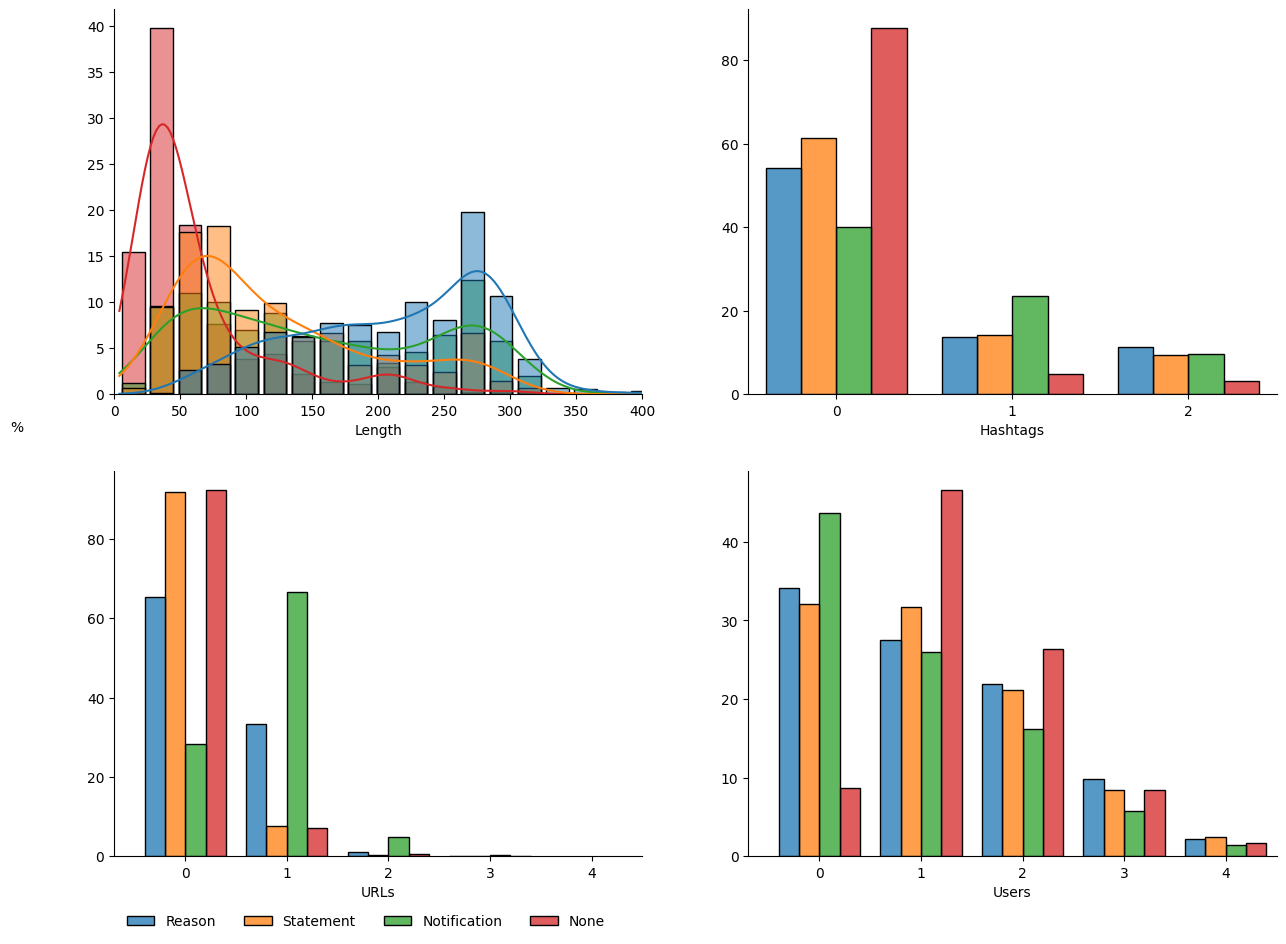

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

for variable, ax, ay in [
    ('length', 0, 0),
    ('hashtags', 0, 1),
    ('urls', 1, 0),
    ('users', 1, 1)]:

    kde = False
    discrete = True
    bins = 'auto'
    legend = False
    multiple = 'dodge'

    if variable == 'length':
        kde = True
        discrete = False
        multiple = 'layer'
        bins = 20
    
    if ax == 1 and ay == 0:
        legend = True

    a = sns.histplot(ax=axes[ax,ay],
                     data=df_argumentation.sort_values(by='class', key=lambda x: pd.Categorical(x, categories=order_of_label)),
                     x=variable,
                     bins=bins,
                     kde=kde,
                     multiple=multiple,
                     shrink=.8,
                     stat="percent",
                     discrete=discrete,
                     hue="class",
                     common_norm=False,
                     legend=legend,
                     edgecolor="black",
                     linewidth=1)

axes[0,0].set_xticks(range(0, 450, 50))
axes[0,0].set_xlim((0, 400))
axes[0,0].set(xlabel="Length", ylabel=None)

axes[0,1].set_xticks(range(0,3))
axes[0,1].set_xlim((-0.5, 2.5))
axes[0,1].set(xlabel="Hashtags", ylabel=None)

axes[1,0].set_xticks(range(0,5))
axes[1,0].set_xlim((-0.7, 4.5))
axes[1,0].set(xlabel="URLs", ylabel=None)

axes[1,1].set_xticks(range(0,5))
axes[1,1].set_xlim((-0.7, 4.5))
axes[1,1].set(xlabel="Users", ylabel=None)

fig.text(0.06, 0.5, '%', ha='center', va='center')
sns.despine()
sns.move_legend(
    axes[1,0],
    "lower left",
    bbox_to_anchor=(0, -.22),
    ncol=4,
    title=None,
    frameon=False,
    edgecolor='k'
)